# Installation

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/74/dvlrgbz96cz_9yb59920m5hc0000gn/T/pip-req-build-n8ltgpgz
  Running command git clone -q https://github.com/tensorflow/examples.git /private/var/folders/74/dvlrgbz96cz_9yb59920m5hc0000gn/T/pip-req-build-n8ltgpgz
  Resolved https://github.com/tensorflow/examples.git to commit 56524742e739278cc52e2fcfc978e81d64cfcbd3


In [2]:
import os
import time

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [3]:
# Enable eager execution for variable declarations.
tf.config.run_functions_eagerly(True)

# Custom Dataset

In [5]:
train_clouds = tfds.load("clouds")["train"]
train_people = tfds.load("people")["train"]

# Constants

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def random_crop(image):
    cropped = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped

In [8]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [9]:
def jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [10]:
def preprocess_image_train(image):
    image = image["image"]
    image = jitter(image)
    image = normalize(image)
    return image

In [11]:
def preprocess_image_test(image):
    image = normalize(image)
    return image

In [12]:
train_clouds = train_clouds.map(preprocess_image_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_people = train_people.map(preprocess_image_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
sample_clouds = next(iter(train_clouds))
sample_people = next(iter(train_people))

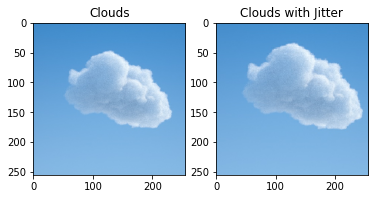

In [14]:
plt.subplot(121)
plt.title("Clouds")
plt.imshow(sample_clouds[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Clouds with Jitter")
plt.imshow(jitter(sample_clouds[0]) * 0.5 + 0.5)

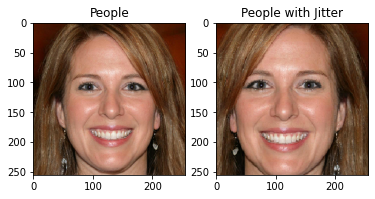

In [16]:
plt.subplot(121)
plt.title("People")
plt.imshow(sample_people[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("People with Jitter")
plt.imshow(jitter(sample_people[0]) * 0.5 + 0.5)

# Pix2Pix Setup

In [17]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target=False)

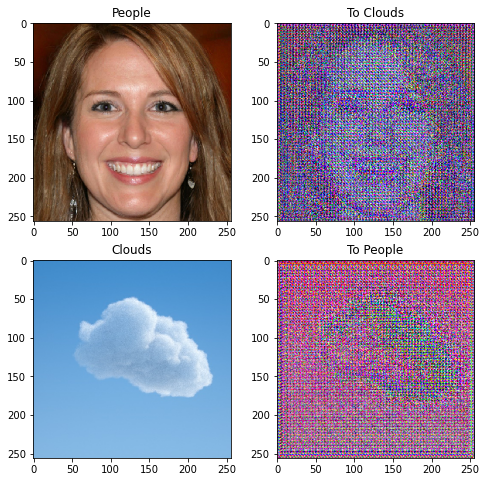

In [18]:
to_clouds = generator_g(sample_people)
to_people = generator_f(sample_clouds)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_people, to_clouds, sample_clouds, to_people]
title = ["People", "To Clouds", "Clouds", "To People"]

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

plt.show()

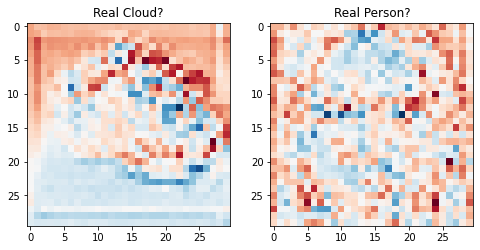

In [19]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title("Real Cloud?")
plt.imshow(discriminator_y(sample_clouds)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title("Real Person?")
plt.imshow(discriminator_x(sample_people)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss Function

In [20]:
LAMBDA = 10

In [21]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [23]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [24]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [25]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint Setup

In [28]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

# Training

In [29]:
EPOCHS = 40

In [30]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ["Input Image", "Predicted Image"]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Get the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [31]:
@tf.function
def train_step(real_x, real_y):
    # Persistent is set to True because the tape is used more than once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate the loss.
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator.
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer.
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

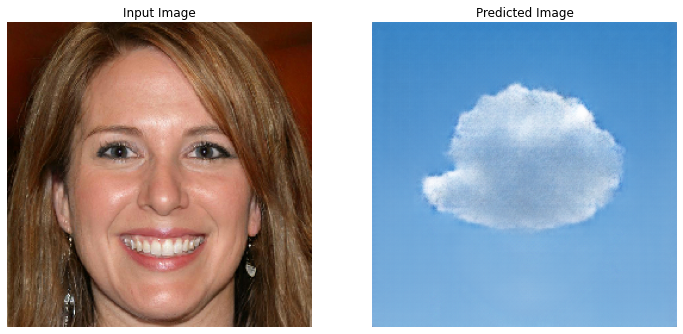

Time taken for epoch 12 is 4043.6599111557007 sec

..............................

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_people, train_clouds)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print(".", end="")
        n += 1
    clear_output(wait=True)
    # Using a consistent image (sample_clouds) so that the progress of the model is clearly visible.
    generate_images(generator_g, sample_people)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch+1,ckpt_save_path))
    print("Time taken for epoch {} is {} sec\n".format(epoch + 1, time.time()-start))

# Test

In [ ]:
for image in test_horses.take(5):
    generate_images(generator_g, image)